# Predict volume area from LiDAR features

In [1]:
from fastai.data.all import *
from fastai.tabular.all import *
from fastai.callback.progress import ShowGraphCallback

In [2]:
absolute_path = Path().absolute()
sys.path.append(str(absolute_path.parents[0]))

from enveco.tabular.preprocessing import *
from enveco.interpretation import *
from enveco.model.ensemble import *
from enveco.metrics import *

/home/mayrajeo/miniconda3/envs/enveco/lib/python3.8/site-packages/tqdm/std.py:697: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


Run the example workflow for predicting the volume of the field plot from LiDAR-derived features.

# Read and preprocess data

In [3]:
#data_path = Path('../../../andras/ml/AV_leafon/')
data_path = Path('../../enveco_data/enveco/')

preprocessor = EnvecoPreprocessor(data_path/'AV.leaf.on.train.csv', 
                                  data_path/'AV.leaf.on.val.csv',
                                  data_path/'AV.leaf.on.test.csv')

Preprocess dataframes and extract lidar features from them. Specify which features are needed:

* height_features
* point_features
* intensity_features
* height_quantiles
* point_proportions
* canopy_densities

Also, specify whether to `normalize` data (default: True) or to log-transform target column (default: False)

In [4]:
preprocessor.train_df.head()

,sampleplotid,x,y,measurementdate,g,d,h,v,v_ma,v_ku,v_lp,myear,filename_1,a_date_1,a_window_1,filename_2,a_date_2,a_window_2,v_lp_proc,is_valid
0,901034,313598.50,6888193.46,2013,30.0,25.9,23.9,336.62,50.11,27.73,258.78,2013,/wrk/project_ogiir-csc/mml/laserkeilaus/2008_17_automaattinen/2013/20130114_BLOM_ahtari_block2_kesa/1/N4121B3.laz,2013-07-11,C,NaN,NaN,NaN,77,0
1,901038,314591.78,6888461.84,2013,18.6,16.0,15.9,146.00,142.50,0.00,3.50,2013,/wrk/project_ogiir-csc/mml/laserkeilaus/2008_17_automaattinen/2013/20130114_BLOM_ahtari_block2_kesa/1/N4121D1.laz,2013-07-11,C,NaN,NaN,NaN,2,0
2,901044,317890.37,6888182.49,2013,26.8,18.4,18.4,240.46,139.89,81.77,18.79,2013,/wrk/project_ogiir-csc/mml/laserkeilaus/2008_17_automaattinen/2013/20130114_BLOM_ahtari_block2_kesa/1/N4121D3.laz,2013-07-11,C,NaN,NaN,NaN,8,0
3,901048,318879.42,6888447.55,2013,34.3,20.2,19.3,321.29,72.10,172.35,76.84,2013,/wrk/project_ogiir-csc/mml/laserkeilaus/2008_17_automaattinen/2013/20130114_BLOM_ahtari_block2_kesa/1/N4121D3.laz,2013-07-11,C,NaN,NaN,NaN,24,0
4,901054,322193.41,6888196.04,2013,13.8,10.0,9.1,67.10,57.40,9.70,0.00,2013,/wrk/project_ogiir-csc/mml/laserkeilaus/2008_17_automaattinen/2013/20130114_BLOM_ahtari_block2_kesa/1/N4121F1.laz,2013-07-11,C,NaN,NaN,NaN,0,0


In [5]:
trainval_tb, test_tb = preprocessor.preprocess_lidar(target_col=['v'], path=data_path/'AV_las/', 
                                                     min_h=1.5,
                                                     height_features=True,
                                                     point_features=True, 
                                                     intensity_features=True, 
                                                     height_quantiles=True,
                                                     point_proportions=True, 
                                                     canopy_densities=True,
                                                     normalize=True,
                                                     log_y=False)

100%|██████████| 225/225 [00:08<00:00, 25.03it/s]


Previous method returns two `TabularPandas` objects. Put them to dataloaders.

In [6]:
dls = trainval_tb.dataloaders(bs=64, y_block=RegressionBlock())

Check the distribution of the target variable `g`, in order to get limits for `sigmoid_range`.

In [7]:
trainval_tb.train.y.describe()

count    1044.000000
mean      145.712250
std        86.097336
min         2.700000
25%        80.927498
50%       132.125000
75%       191.305000
max       867.349976
Name: v, dtype: float64

In [8]:
trainval_tb.valid.y.describe()

count    225.000000
mean     150.768631
std       95.610825
min        2.310000
25%       87.419998
50%      133.600006
75%      191.639999
max      539.479980
Name: v, dtype: float64

In [9]:
test_tb.train.y.describe()

count    225.000000
mean     152.013641
std       97.223846
min        7.000000
25%       87.820000
50%      134.979996
75%      192.529999
max      550.169983
Name: v, dtype: float64

# ANN

Create `Learner` object. Specify y_range to better control the training, set 1000 m³ as the maximum value for the total volume.

Loss function is Mean Squared Error, monitor also Root Mean Squared Error, mean-normalized RMSE, Mean Absolute Error, R2Score, bias and mean-scaled bias. Target variable is log-transformed, so all metrics are log-equivalents (so MSLE, RMSLE...).

In [10]:
learn = tabular_learner(dls, metrics=[rmse, rrmse, bias, bias_pct, mae, R2Score()],  y_range=(0,1000))
learn.summary()

TabularModel (Input shape: ['64 x 0', '64 x 70'])
Layer (type)         Output Shape         Param #    Trainable 
BatchNorm1d          64 x 70              140        True      
________________________________________________________________
BatchNorm1d          64 x 70              140        True      
________________________________________________________________
Linear               64 x 200             14,000     True      
________________________________________________________________
ReLU                 64 x 100             0          False     
________________________________________________________________
BatchNorm1d          64 x 200             400        True      
________________________________________________________________
Linear               64 x 100             20,000     True      
________________________________________________________________
ReLU                 64 x 100             0          False     
________________________________________________

Find learning rate to use.

SuggestedLRs(lr_min=0.33113112449646, lr_steep=0.0020892962347716093)

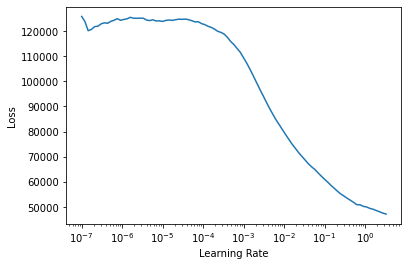

In [11]:
learn.lr_find()

1e-2 seems to be a good learning rate.

epoch,train_loss,valid_loss,_rmse,_rrmse,_bias,_bias_pct,mae,r2_score,time
0,115170.632812,107385.914062,327.697906,217.351501,316.452606,209.892868,316.676849,-10.799611,00:00
1,92334.234375,54850.632812,234.202103,155.338745,220.255936,146.088699,221.064484,-5.027011,00:00
2,62817.527344,12359.433594,111.172997,73.737488,66.878128,44.358120,94.726440,-0.358060,00:00
3,40955.261719,3187.540283,56.458305,37.446983,15.859887,10.519355,42.395374,0.649752,00:00
4,27598.533203,1985.627319,44.560379,29.555470,2.333754,1.547904,32.095806,0.781818,00:00
5,19330.027344,2128.221680,46.132656,30.598312,-5.366141,-3.559190,31.604214,0.766150,00:00
6,13852.958008,1653.687744,40.665562,26.972162,7.991377,5.300425,28.154795,0.818292,00:00
7,10137.507812,1910.430420,43.708469,28.990427,-3.135719,-2.079822,30.742176,0.790081,00:00
8,7567.741211,1765.186157,42.014118,27.866617,11.327388,7.513093,27.880070,0.806041,00:00
9,5746.387207,1685.114990,41.050152,27.227249,9.675383,6.417371,27.201199,0.814839,00:00


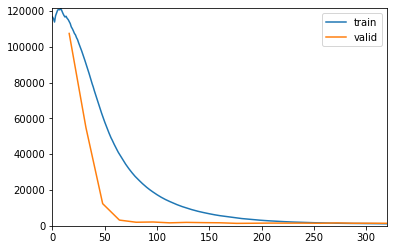

In [12]:
learn.fit_one_cycle(20, max_lr=1e-2, cbs=ShowGraphCallback())

In [13]:
preds, true = learn.get_preds()

In [14]:
preds.shape

torch.Size([225, 1])

See validation results

In [15]:
learn.validate()

(#7) [1397.4482421875,37.3824577331543,24.794586181640625,5.205857276916504,3.452878475189209,25.119972229003906,0.8464478055044939]

`RegressionInterpretation` can be used to plot results.

In [16]:
reg_interp = RegressionInterpretation.from_learner(learn, ds_idx=1)

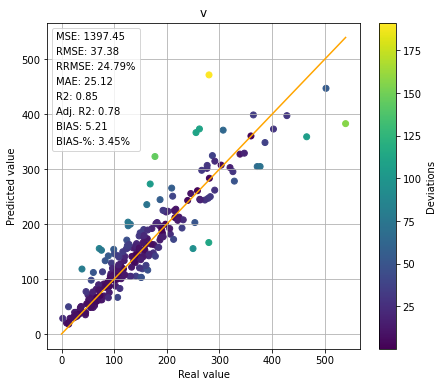

In [17]:
reg_interp.plot_results()
plt.show()

Evaluate test set.

In [18]:
test_dls = test_tb.dataloaders(y_block=RegressionBlock(), shuffle_train=False, drop_last=False)

In [19]:
test_interp = RegressionInterpretation.from_learner(learn, dl=test_dls.train, ds_idx=0)

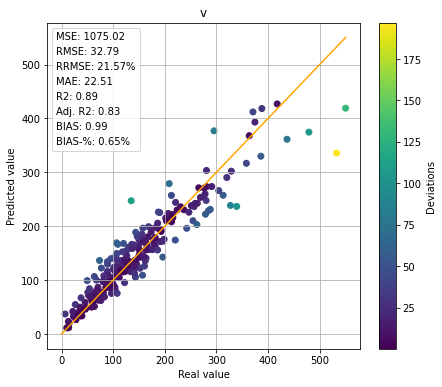

In [20]:
test_interp.plot_results()
plt.show()

# Ensemble of ANNs

Fit several models at once.

In [25]:
ensemble = Ensemble(dls, learn_func=tabular_learner,
                    y_range=(0,trainval_tb.y.max() * 1.1), 
                    metrics=[rmse, rrmse, bias, bias_pct, mae, R2Score()], 
                    n_models=10)

In [26]:
ensemble.fit_one_cycle(20, 1e-2)

epoch,train_loss,valid_loss,_rmse,_rrmse,_bias,_bias_pct,mae,r2_score,time
0,81424.726562,84316.468750,290.372986,192.595093,275.237213,182.556015,278.195343,-8.264731,00:00
1,65299.429688,41695.964844,204.195908,135.436600,187.566559,124.406891,192.254578,-3.581571,00:00
2,44023.570312,7392.727051,85.980972,57.028423,49.256451,32.670223,69.659401,0.187684,00:00
3,28598.986328,4146.007812,64.389503,42.707493,18.354959,12.174256,41.949200,0.544435,00:00
4,19477.585938,2532.555908,50.324505,33.378632,10.804302,7.166147,33.456188,0.721722,00:00
5,13709.869141,2053.648193,45.317200,30.057446,11.218093,7.440602,30.067089,0.774344,00:00
6,9922.253906,1827.141479,42.745075,28.351439,7.258343,4.814226,29.136400,0.799233,00:00
7,7406.316406,2344.444824,48.419472,32.115086,17.421982,11.555443,31.367359,0.742391,00:00
8,5563.372559,1879.117065,43.348785,28.751860,10.907912,7.234869,28.508688,0.793522,00:00
9,4298.699707,2445.446777,49.451458,32.799564,15.818201,10.491706,31.471449,0.731293,00:00


epoch,train_loss,valid_loss,_rmse,_rrmse,_bias,_bias_pct,mae,r2_score,time
0,108010.875000,96141.343750,310.066681,205.657288,296.772003,196.839355,297.638947,-9.564053,00:00
1,86214.773438,46297.253906,215.167969,142.714005,194.672333,129.119919,198.698196,-4.087162,00:00
2,57773.636719,9053.949219,95.152245,63.111435,51.877228,34.408501,78.958710,0.005148,00:00
3,37354.687500,2849.220947,53.378090,35.403976,7.845978,5.203986,38.206200,0.686926,00:00
4,25299.949219,2062.451904,45.414227,30.121799,-3.421544,-2.269400,33.280849,0.773377,00:00
5,17752.375000,1770.983521,42.083054,27.912340,6.251600,4.146486,29.988598,0.805404,00:00
6,12760.625000,1652.632324,40.652580,26.963552,1.291058,0.856318,28.725765,0.818408,00:00
7,9356.889648,1530.742310,39.124702,25.950161,8.661191,5.744690,27.192577,0.831801,00:00
8,7063.290527,1542.827759,39.278847,26.052401,7.503091,4.976560,27.090948,0.830473,00:00
9,5348.819336,1408.894409,37.535244,24.895924,4.967426,3.294734,25.805904,0.845190,00:00


epoch,train_loss,valid_loss,_rmse,_rrmse,_bias,_bias_pct,mae,r2_score,time
0,98101.304688,89369.414062,298.947174,198.282074,287.043671,190.386871,287.677124,-8.819948,00:00
1,77406.101562,41129.808594,202.804871,134.513977,184.055725,122.078262,189.043747,-3.519361,00:00
2,51945.585938,7956.862305,89.201248,59.164326,53.471581,35.465988,75.347710,0.125697,00:00
3,33750.394531,2607.653320,51.065186,33.869900,7.831803,5.194584,37.028515,0.713470,00:00
4,22969.025391,1978.789185,44.483582,29.504534,-5.683236,-3.769508,31.500208,0.782570,00:00
5,16210.832031,1666.813354,40.826626,27.078993,7.944631,5.269419,28.555611,0.816850,00:00
6,11698.535156,1760.916382,41.963276,27.832895,11.455278,7.597919,28.307907,0.806510,00:00
7,8605.360352,1609.153198,40.114250,26.606497,10.248457,6.797473,26.961115,0.823186,00:00
8,6492.134766,1412.165649,37.578793,24.924809,7.614648,5.050552,25.599045,0.844831,00:00
9,4974.536133,1336.661011,36.560375,24.249325,6.426277,4.262343,24.553787,0.853127,00:00


epoch,train_loss,valid_loss,_rmse,_rrmse,_bias,_bias_pct,mae,r2_score,time
0,96726.070312,94605.406250,307.579895,204.007889,291.602753,193.410767,293.754364,-9.395282,00:00
1,76710.445312,43733.574219,209.125732,138.706390,191.110092,126.757202,195.785324,-3.805464,00:00
2,51675.101562,8840.864258,94.025871,62.364346,49.294128,32.695217,75.919777,0.028562,00:00
3,33603.140625,2456.067139,49.558723,32.870712,6.599847,4.377467,36.399097,0.730126,00:00
4,22858.664062,1805.996094,42.497009,28.186905,-3.718679,-2.466480,30.037584,0.801556,00:00
5,16080.377930,1541.304688,39.259457,26.039537,7.480510,4.961582,27.193026,0.830641,00:00
6,11572.268555,1669.300781,40.857079,27.099190,9.771933,6.481410,27.224442,0.816577,00:00
7,8508.736328,1594.615234,39.932632,26.486036,7.993042,5.301528,26.632912,0.824783,00:00
8,6404.929688,1526.199585,39.066605,25.911627,6.482667,4.299746,25.960213,0.832301,00:00
9,4898.527832,1494.150391,38.654243,25.638121,8.218979,5.451385,26.103504,0.835822,00:00


epoch,train_loss,valid_loss,_rmse,_rrmse,_bias,_bias_pct,mae,r2_score,time
0,126517.492188,107375.046875,327.681305,217.340515,311.839417,206.833084,312.255981,-10.798416,00:00
1,102122.007812,58836.238281,242.561829,160.883484,228.663452,151.665146,230.173096,-5.464951,00:00
2,70247.859375,12996.953125,114.004181,75.615318,74.367233,49.325401,99.792542,-0.428111,00:00
3,45809.906250,3886.862305,62.344711,41.351250,22.430021,14.877114,45.440598,0.572910,00:00
4,30940.658203,2838.096191,53.273777,35.334789,11.090553,7.356008,36.723186,0.688149,00:00
5,21622.892578,1992.824585,44.641064,29.608986,8.189700,5.431966,31.953428,0.781028,00:00
6,15467.103516,1660.858765,40.753632,27.030579,2.617079,1.735825,28.748224,0.817504,00:00
7,11281.188477,1542.782104,39.278263,26.052013,6.647984,4.409395,27.278589,0.830478,00:00
8,8365.831055,1427.742065,37.785477,25.061897,5.508689,3.653737,25.462635,0.843119,00:00
9,6329.514160,1423.152222,37.724693,25.021580,1.463231,0.970514,26.056202,0.843623,00:00


epoch,train_loss,valid_loss,_rmse,_rrmse,_bias,_bias_pct,mae,r2_score,time
0,75983.109375,79526.593750,282.004608,187.044617,267.639954,177.517014,269.380951,-7.738416,00:00
1,59068.316406,31157.146484,176.513870,117.075989,158.199860,104.928902,161.948624,-2.423561,00:00
2,38646.996094,5355.270508,73.179710,48.537754,28.826355,19.119596,58.216290,0.411561,00:00
3,25157.513672,2633.109619,51.313839,34.034824,7.118992,4.721799,35.519493,0.710673,00:00
4,17170.714844,1944.764771,44.099483,29.249773,5.562912,3.689702,31.186062,0.786308,00:00
5,12146.916016,1665.177002,40.806583,27.065697,5.787005,3.838335,28.515757,0.817030,00:00
6,8853.692383,1793.319214,42.347603,28.087807,-4.217034,-2.797024,28.042080,0.802949,00:00
7,6643.674316,1534.695312,39.175186,25.983646,-1.788559,-1.186294,27.094522,0.831367,00:00
8,5120.566895,1340.488892,36.612690,24.284023,2.276129,1.509683,25.039930,0.852706,00:00
9,3973.008789,1358.779175,36.861622,24.449133,2.442286,1.619890,25.869091,0.850697,00:00


epoch,train_loss,valid_loss,_rmse,_rrmse,_bias,_bias_pct,mae,r2_score,time
0,88950.375000,90292.765625,300.487549,199.303757,288.432617,191.308105,289.217957,-8.921409,00:00
1,69804.265625,38179.687500,195.396225,129.600052,176.729233,117.218842,180.341156,-3.195200,00:00
2,46076.960938,6463.426758,80.395439,53.323715,38.135620,25.294134,65.668106,0.289796,00:00
3,29849.054688,3072.890869,55.433662,36.767372,10.337246,6.856364,38.292709,0.662349,00:00
4,20322.580078,1641.022461,40.509537,26.868677,-1.071177,-0.710478,28.744516,0.819684,00:00
5,14264.461914,1487.638916,38.569923,25.582195,7.242676,4.803835,26.712357,0.836538,00:00
6,10305.999023,1393.781372,37.333385,24.762037,1.264207,0.838508,25.992188,0.846851,00:00
7,7623.396484,1373.686157,37.063271,24.582880,-0.997015,-0.661288,25.708841,0.849059,00:00
8,5739.065918,1377.200684,37.110653,24.614305,3.577586,2.372898,25.095636,0.848673,00:00
9,4405.668457,1611.323364,40.141293,26.624432,9.185000,6.092116,26.860924,0.822947,00:00


epoch,train_loss,valid_loss,_rmse,_rrmse,_bias,_bias_pct,mae,r2_score,time
0,59130.031250,66334.585938,257.555023,170.828003,240.455795,159.486618,243.143387,-6.288873,00:00
1,45356.421875,26025.417969,161.323959,107.001007,142.311676,94.390778,147.473999,-1.859684,00:00
2,29438.560547,4537.823242,67.363365,44.679962,27.482786,18.228451,53.644363,0.501382,00:00
3,19171.833984,2249.064209,47.424301,31.455019,-7.928467,-5.258698,34.402092,0.752872,00:00
4,13214.889648,1834.511108,42.831192,28.408558,0.610482,0.404913,29.993170,0.798423,00:00
5,9457.114258,1640.421143,40.502113,26.863754,9.302751,6.170217,28.114088,0.819750,00:00
6,6959.777832,1747.703979,41.805550,27.728281,-0.874971,-0.580341,28.362883,0.807962,00:00
7,5264.135742,1549.287964,39.360996,26.106888,7.492805,4.969738,26.763784,0.829764,00:00
8,4061.242920,1634.945801,40.434464,26.818884,0.427701,0.283680,27.252241,0.820351,00:00
9,3178.995850,1521.722656,39.009262,25.873592,1.928854,1.279347,26.671839,0.832792,00:00


epoch,train_loss,valid_loss,_rmse,_rrmse,_bias,_bias_pct,mae,r2_score,time
0,103369.570312,96274.429688,310.281219,205.799576,297.744141,197.484146,298.125275,-9.578676,00:00
1,82715.625000,47202.117188,217.260483,144.101913,199.708176,132.460037,202.659531,-4.186589,00:00
2,56014.328125,10232.955078,101.158073,67.094910,58.700233,38.933983,83.954964,-0.124402,00:00
3,36574.179688,3596.264893,59.968864,39.775425,17.681141,11.727334,43.072041,0.604841,00:00
4,24756.166016,2377.841553,48.763115,32.343014,6.091376,4.040214,33.600883,0.738722,00:00
5,17301.634766,1839.192627,42.885811,28.444784,3.955459,2.623529,30.124662,0.797909,00:00
6,12428.890625,1652.463013,40.650497,26.962173,5.511009,3.655276,28.019409,0.818427,00:00
7,9127.679688,1756.801514,41.914215,27.800354,7.892561,5.234883,29.177671,0.806962,00:00
8,6866.216309,2238.772705,47.315670,31.382965,12.031338,7.980001,30.851805,0.754003,00:00
9,5266.339355,1824.368896,42.712631,28.329918,-3.322619,-2.203787,29.660572,0.799538,00:00


epoch,train_loss,valid_loss,_rmse,_rrmse,_bias,_bias_pct,mae,r2_score,time
0,104420.484375,104110.945312,322.662292,214.011551,310.752045,206.111877,311.487000,-10.439756,00:00
1,84132.195312,48735.511719,220.761200,146.423828,203.674164,135.090546,207.306473,-4.355079,00:00
2,57174.437500,9818.562500,99.088661,65.722336,58.849934,39.033272,83.261253,-0.078868,00:00
3,37144.476562,2914.442871,53.985584,35.806908,14.718708,9.762447,39.076046,0.679760,00:00
4,25139.257812,1891.694580,43.493618,28.847923,-5.728736,-3.799687,30.248816,0.792140,00:00
5,17603.750000,1500.575928,38.737267,25.693188,2.221692,1.473577,26.862217,0.835116,00:00
6,12673.444336,1784.798828,42.246880,28.021002,11.739188,7.786227,29.127159,0.803886,00:00
7,9306.780273,1716.928711,41.435841,27.483065,9.197034,6.100098,27.764982,0.811343,00:00
8,6948.165039,1579.626099,39.744511,26.361259,10.033866,6.655142,27.339575,0.826430,00:00
9,5258.429199,1318.216797,36.307255,24.081438,6.932745,4.598268,24.688099,0.855154,00:00


In [27]:
res = ensemble.validate()

See ensemble validation results.

In [28]:
res

,model_identifier,_rmse,_rrmse,_bias,_bias_pct,mae,r2_score
0,ensemble,35.229649,23.366697,7.525651,4.991523,22.845997,0.863624
1,0,39.182144,25.988260,9.996769,6.630536,25.551178,0.831307
2,1,37.255264,24.710222,5.246808,3.480039,24.622749,0.847491
3,2,36.681477,24.329647,9.666723,6.411627,24.539257,0.852152
4,3,37.202652,24.675325,6.592613,4.372669,24.319954,0.847921
5,4,36.983593,24.530033,8.068172,5.351359,25.164522,0.849707
6,5,36.748707,24.374239,8.820621,5.850435,25.185799,0.851610
7,6,38.180599,25.323967,5.830385,3.867107,25.436520,0.839821
8,7,38.280357,25.390133,7.894315,5.236046,25.436459,0.838983
9,8,38.306202,25.407276,8.492904,5.633070,25.603687,0.838765


In [29]:
ens_int = RegressionInterpretation.from_ensemble(ensemble)

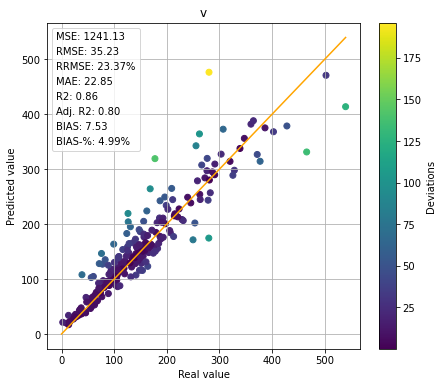

In [30]:
ens_int.plot_results()
plt.show()

Run test set predictions.

In [31]:
test_res = ensemble.validate(dl=test_dls[0])
test_res

,model_identifier,_rmse,_rrmse,_bias,_bias_pct,mae,r2_score
0,ensemble,32.427303,21.331839,1.678144,1.103943,21.746830,0.888260
1,0,33.009171,21.714611,3.027473,1.991580,23.176485,0.884213
2,1,35.551960,23.387348,-0.796057,-0.523675,23.696760,0.865688
3,2,35.413643,23.296360,3.198825,2.104301,24.590319,0.866731
4,3,34.264111,22.540155,1.485572,0.977262,22.732586,0.875242
5,4,34.799870,22.892595,2.398674,1.577933,23.830927,0.871310
6,5,34.118679,22.444485,3.482902,2.291177,23.881903,0.876299
7,6,36.809944,24.214895,0.467735,0.307693,24.284367,0.856014
8,7,32.818436,21.589140,1.578761,1.038565,22.201990,0.885548
9,8,35.142094,23.117723,2.636812,1.734589,24.423002,0.868767


In [32]:
run_test_res = test_res[test_res.model_identifier != 'ensemble']

In [33]:
test_ens_interp = RegressionInterpretation.from_ensemble(ensemble, dl=test_dls[0])

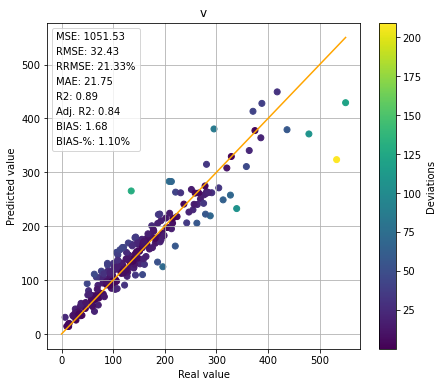

In [34]:
test_ens_interp.plot_results()
plt.show()

# Comparison: Random forest

`TabularPandas` makes it simple to use sklearn models with the same data and preprocessing.

In [35]:
from sklearn.ensemble import RandomForestRegressor

Below values for max_features and min_samples_leaf should generally work well.

In [36]:
rf = RandomForestRegressor(n_estimators=500, max_features=0.5, min_samples_leaf=4, oob_score=True)

In [37]:
rf.fit(trainval_tb.train.xs, trainval_tb.train.ys.values.ravel())

RandomForestRegressor(max_features=0.5, min_samples_leaf=4, n_estimators=500,
                      oob_score=True)

In [38]:
rf_preds = rf.predict(trainval_tb.valid.xs)

Validation results

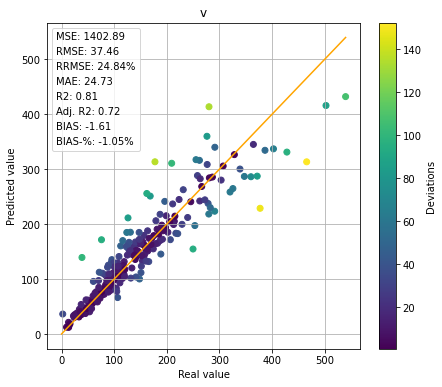

In [39]:
plot_sklearn_regression(rf, trainval_tb.valid.xs, trainval_tb.valid.ys)
plt.show()

Test results

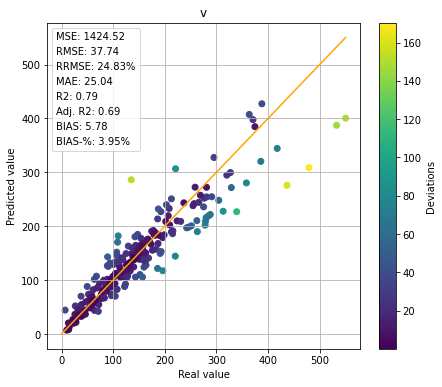

In [40]:
plot_sklearn_regression(rf, test_tb.train.xs, test_tb.train.ys)
plt.show()